In [15]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [16]:
input_shape = (224,224,3)
resnet_weights_path = 'imagenet'
num_classes = 200
image_size = 224
batch_size = 64

In [17]:
data_generator = ImageDataGenerator(
    preprocessing_function = preprocess_input,
                                    )
train_generator = data_generator.flow_from_directory('/Users/brycemartin/Documents/AI/bird-class-data/Train',
                                                    target_size = (image_size,image_size),
                                                    batch_size = batch_size, 
                                                    shuffle = True, 
                                                    class_mode = 'categorical')

test_generator = data_generator.flow_from_directory('/Users/brycemartin/Documents/AI/bird-class-data/Test',
                                                    target_size = (image_size,image_size),
                                                    batch_size = batch_size, 
                                                    shuffle = False,
                                                    class_mode = 'categorical')

Found 9414 images belonging to 200 classes.
Found 2374 images belonging to 200 classes.


In [18]:
class_names = list(train_generator.class_indices.keys())

# Print the class names as a list
print("Class names:", class_names)

Class names: ['Acadian_Flycatcher', 'American_Crow', 'American_Goldfinch', 'American_Pipit', 'American_Redstart', 'American_Three_toed_Woodpecker', 'Anna_Hummingbird', 'Artic_Tern', 'Baird_Sparrow', 'Baltimore_Oriole', 'Bank_Swallow', 'Barn_Swallow', 'Bay_breasted_Warbler', 'Belted_Kingfisher', 'Bewick_Wren', 'Black_Tern', 'Black_and_white_Warbler', 'Black_billed_Cuckoo', 'Black_capped_Vireo', 'Black_footed_Albatross', 'Black_throated_Blue_Warbler', 'Black_throated_Sparrow', 'Blue_Grosbeak', 'Blue_Jay', 'Blue_headed_Vireo', 'Blue_winged_Warbler', 'Boat_tailed_Grackle', 'Bobolink', 'Bohemian_Waxwing', 'Brandt_Cormorant', 'Brewer_Blackbird', 'Brewer_Sparrow', 'Bronzed_Cowbird', 'Brown_Creeper', 'Brown_Pelican', 'Brown_Thrasher', 'Cactus_Wren', 'California_Gull', 'Canada_Warbler', 'Cape_Glossy_Starling', 'Cape_May_Warbler', 'Cardinal', 'Carolina_Wren', 'Caspian_Tern', 'Cedar_Waxwing', 'Cerulean_Warbler', 'Chestnut_sided_Warbler', 'Chipping_Sparrow', 'Chuck_will_Widow', 'Clark_Nutcracker',

In [19]:
base_model = ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path, input_shape=input_shape)
base_model.trainable = True  # Fine-tune the entire base model

inputs = tf.keras.Input(shape=input_shape)
x = base_model(inputs, training=True)
outputs = Dense(num_classes, activation='softmax')(x)
my_new_model = Model(inputs, outputs)

In [20]:
my_new_model.layers[0].trainable = True

In [21]:
with tf.device('/GPU:0'):    
    base_model.trainable = False
    my_new_model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
        metrics=['accuracy']
    )
    history = my_new_model.fit(
        train_generator,
        steps_per_epoch=100,
        validation_data=test_generator,
        epochs=5
    )

    # Unfreeze the base model and fine-tune the entire model
    base_model.trainable = True
    my_new_model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),  # Lower learning rate
        metrics=['accuracy']
    )
    history_finetune = my_new_model.fit(
        train_generator,
        steps_per_epoch=100,
        validation_data=test_generator,
        epochs=5
    )

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 634ms/step - accuracy: 0.0934 - loss: 4.7835 - val_accuracy: 0.3686 - val_loss: 2.7303
Epoch 2/5
 48/100 ━━━━━━━━━━━━━━━━━━━━ 23s 444ms/step - accuracy: 0.4666 - loss: 2.3166

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 377ms/step - accuracy: 0.4819 - loss: 2.2344 - val_accuracy: 0.4553 - val_loss: 2.2820
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 62s 624ms/step - accuracy: 0.5710 - loss: 1.7956 - val_accuracy: 0.5194 - val_loss: 1.9284
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 400ms/step - accuracy: 0.6764 - loss: 1.3407 - val_accuracy: 0.5476 - val_loss: 1.7803
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 71s 716ms/step - accuracy: 0.7433 - loss: 1.1294 - val_accuracy: 0.5725 - val_loss: 1.6800
Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 273s 3s/step - accuracy: 0.6982 - loss: 1.3202 - val_accuracy: 0.6154 - val_loss: 1.4165
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.8747 - loss: 0.6450 - val_accuracy: 0.6710 - val_loss: 1.1902
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.9042 - loss: 0.5422 - val_accuracy: 0.6879 - val_loss: 1.1485
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.9447 - loss: 0.4019 - val_accuracy: 0.68

In [22]:
my_new_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │       409,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,941,906 (182.88 MB)

 Trainable params: 23,944,392 (91.34 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 23,944,394 (91.34 MB)

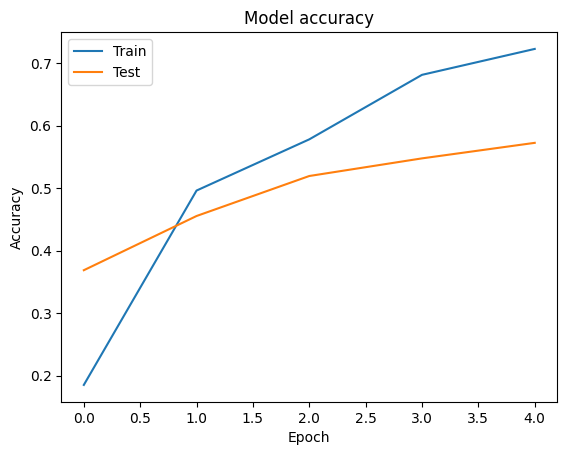

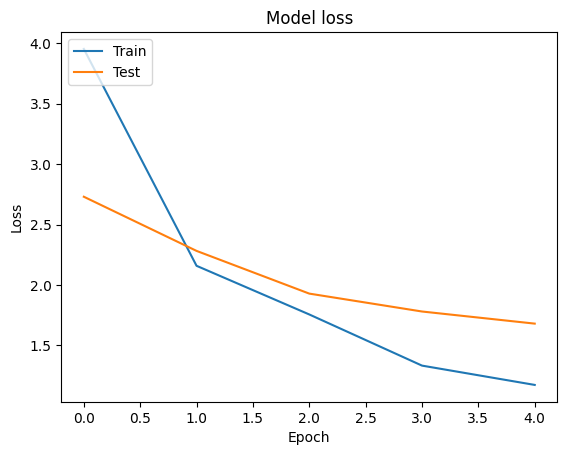

In [23]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [24]:
my_new_model.evaluate(test_generator)

38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 494ms/step - accuracy: 0.7032 - loss: 1.0992


[1.1246143579483032, 0.6971356272697449]

In [25]:
my_new_model.save("./bird-classification2.keras")